# Lecture : Graph Transformers & Graph ViT

## Lab 01 : Vanilla Graph Transformers (GT without Positional Encoding) -- Solution

### Xavier Bresson, Guoji Fu

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [2]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

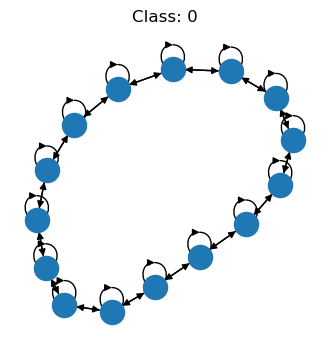

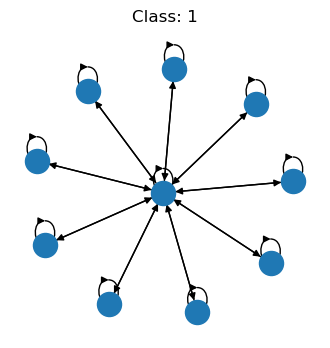

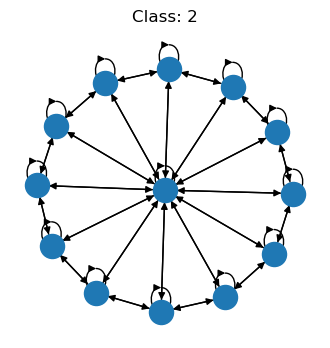

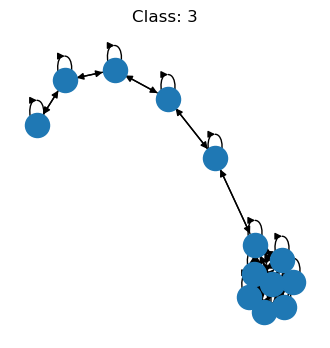

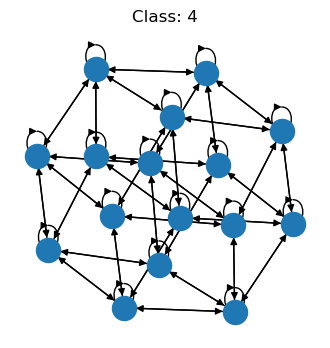

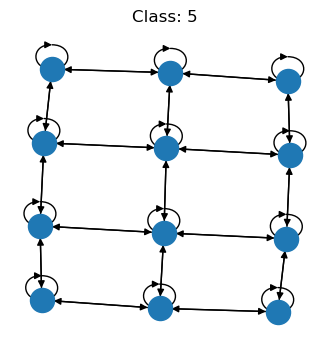

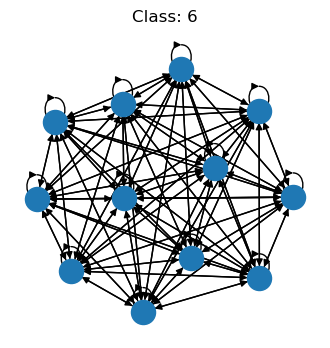

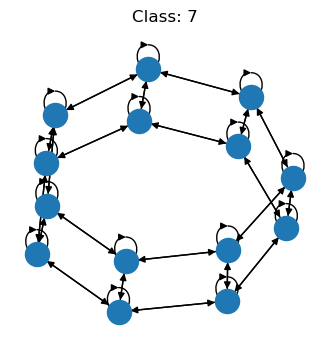

In [3]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c]
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Exercise 1: Generate train, val and test datasets

### Question 1.1: Add node features

**Instructions**:

- Compute the in-degree for each node using ```g.in_degrees()```.

- Reshape and convert the in-degrees to a floating-point tensor with shape ```(number_of_nodes, 1)``` using ```.view(-1, 1).float()```.

- Assign node features to graphs by storing these features in the ```ndata``` dictionary with the key ```'feat'```: ```g.ndata['feat']```.

In [4]:
# Add node features to graphs
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        ###############################################
        # YOUR CODE STARTS
        ###############################################

        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()

        ###############################################
        # YOUR CODE ENDS
        ###############################################

    return dataset


In [5]:
# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])

(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


### Question 1.2: Define the collate function to prepare a batch of DGL graphs and test it

**Instructions:**

- Use ```map()``` and ```zip()``` to unpack the samples into separate graphs and labels lists.

- Use DGL's batch function ```dgl.batch()``` to combine the list of individual graphs into a single batched graph.

- Transform the list of labels into a PyTorch tensor using ```torch.tensor()```.

In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    ###############################################
    # YOUR CODE ENDS
    ###############################################

    return batch_graphs, batch_labels


In [7]:
# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())

Graph(num_nodes=140, num_edges=988,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([4, 0, 4, 3, 3, 3, 4, 7, 0, 6])
batch_x: torch.Size([140, 1])


# Exercise 2: Design the class of vanilla GraphTransformer networks with DGL

Node update equation:  
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h)=\textrm{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}, A_G\in \mathbb{R}^{N\times N} \textrm{ (graph adjacency matrix)}\\
&&\quad\quad\ \textrm{gHA}(h)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, W_Q, W_K, W_V\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}(h_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature)}\\
\end{eqnarray*}


### Implement a MLP layer for classification

In [8]:
# class MLP layer for classification
class MLP_layer(nn.Module):

    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L

    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

### Question 2.1: Implement a Graph Multi-Head Attention (MHA) Layer with DGL

**Instructions:**

- *Step 1 of message-passing with DGL:* Pass node feature and edge features along edges (src/j => dst/i) by:
    - *Step 1.1:* Compute $q_i^T * k_j$. You may use ```edges.dst[]``` for ```i, edges.src[]``` for ```j

    - *Step 1.2:* Compute $\textrm{exp}_{ij} = \exp( q_i^T * k_j / \sqrt{d'} )$, ```size=(E,K,1)```.

    - *Step 1.3:* Obtain ```V``` by ```edges.src['V'], size=(E,K,d')```.

- *Step 2 of message-passing with DGL:* Define a reduce function that
    - *Step 2.1:* Use ```nodes.mailbox[]``` to collects all messages ```= {vj, eij}``` sent to node dst/i with *Step 1*.
    
    - *Step 2.2:* Sum/mean over the graph neigbors ```j``` in ```Ni```.

- Assign ```Q, K, V```  to graphs by storing them in the ndata dictionary with the keys ```'Q', 'K', 'V'```: ```g.ndata['Q'], g.ndata['K'], g.ndata['V']``` and reshape them using ```.view(-1, num_heads, head_hidden_dim)```.

In [ ]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        # WQ, WK, WV shapes = d' x d'
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    def message_func(self, edges):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 1.1: Compute q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        qikj = (edges.src['K'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # [bs, n, 1, d]

        # Step 1.2: Compute exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        # Calculate the numerator part of gHA(h)_i
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) ) 

        # Step 1.3: Obtain V
        vj = edges.src['V'] # size=(E,K,d')
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    # Here we finish the calculation for gHA(h)_i
    def reduce_func(self, nodes):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 2.1: Collects all messages= eij
        # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        expij = nodes.mailbox['expij']

        # Step 2.1: Collects all messages= vj
        # size=(N,|Nj|,K,d')
        vj = nodes.mailbox['vj']

        # Step 2.2: Sum/mean over the graph neigbors j in Ni
        # sum_j exp_ij . v_j, size=(N,K,d')
        numerator = torch.sum( expij * vj, dim=1 )

        # sum_j' exp_ij', size=(N,K,1)
        denominator = torch.sum( expij, dim=1 )

        # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        h = numerator / denominator
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return {'h' : h}

    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Q= hkWQ [Batch Size, N, d']
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        # K= hkWK [Batch Size, N, d']
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        # V= hkWV [Batch Size, N, d']
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)

        # compute with DGL the graph MHA
        g.update_all(self.message_func, self.reduce_func)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA



### Implement a GraphTransformer layer

In [10]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

    def forward(self, g, h):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N f, d)
        h_MLP = self.linear1(h) # LL, size=(N, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)

        return h

### Question 2.2: Combine all previous defined MLP Layer, GraphTransformer layer to construct the Graph Transformer network

**Instructions:**

- *Input embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input features into node embeddings.

- *Graph transformer layer:* Initialize a ModuleList ```nn.ModuleList()``` containing ```L``` instances of ```GraphTransformer_layer()```.

- *MLP layer:* Initialize a MLP layer ```MLP_layer()``` for classification.

In [ ]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        # self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    def forward(self, g, h):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # input embedding
        # h_0 = LL(h_0)
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.MLP_layer(y) # size=(num_graphs, num_classes)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return y

### Instantiate a graph Transformer network

In [12]:
# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_mha): Dropout(p=0.0, inplace=False)
      (dropout_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True

# Train the network

### Define the accuracy function to compute the prediction accuracy

In [13]:
def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc

### Implement the ```run_one_epoch``` function for training and evaluation

In [14]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores, batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer

### Set up data loaders, initialize the model, and running the training loop for the graph Transformer network

In [15]:
# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

# optimizer
loss_fc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, True, loss_fc, optimizer)
    with torch.no_grad():
        epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, False, loss_fc)
        epoch_val_loss, epoch_val_acc, _ = run_one_epoch(net, val_loader, False, loss_fc)
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                       train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))


Number of parameters: 432648 (0.43 million)
Epoch 0, time 11.4232, train_loss: 2.0162, test_loss: 1.9248, val_loss: 1.9248
                       train_acc: 0.1686, test_acc: 0.1800, val_acc: 0.1800
Epoch 1, time 11.7999, train_loss: 1.8467, test_loss: 1.8015, val_loss: 1.8015
                       train_acc: 0.1800, test_acc: 0.2800, val_acc: 0.2800
Epoch 2, time 12.1444, train_loss: 1.7293, test_loss: 1.6880, val_loss: 1.6880
                       train_acc: 0.3629, test_acc: 0.5700, val_acc: 0.5700
Epoch 3, time 11.2344, train_loss: 1.6065, test_loss: 1.5579, val_loss: 1.5579
                       train_acc: 0.4429, test_acc: 0.3500, val_acc: 0.3500
Epoch 4, time 11.2948, train_loss: 1.4599, test_loss: 1.3962, val_loss: 1.3962
                       train_acc: 0.5343, test_acc: 0.6500, val_acc: 0.6500
Epoch 5, time 11.6076, train_loss: 1.2911, test_loss: 1.2204, val_loss: 1.2204
                       train_acc: 0.6914, test_acc: 0.6800, val_acc: 0.6800
Epoch 6, time 11.2423, tra

## Compare results

| GNN    | train acc | test acc |
| -------- | ------- | ------- |
| GCN  | 0.7829   | 0.7900    |
| GIN | 0.0800     | 0.1000     |
| GAT    | 0.9229    | 0.9400    |
| Vanilla GT    | 0.9229    | 0.9400    |
